# Centralities

In this section, I'm going to learn how Centrality works and try to interpret the data based on small real dataset. I'm using Facebook DataSet from SNAP https://snap.stanford.edu/data/egonets-Facebook.html. The data is included in this repository for easier access. The data is in EdgeList format (source, target).

I'm going to use Networkx, iGraph and graph_tool to find all the centralities.

In [4]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import operator
import timeit

In [4]:
g_fb = nx.read_edgelist('facebook_combined.txt', create_using = nx.Graph(), nodetype = int)

In [6]:
print nx.info(g_fb)

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


In [7]:
print nx.is_directed(g_fb)

False


Now let's find the celebrities. The most basic centrality is Degree Centrality which is the sum of all in and out nodes (in the case of directed graph). 

In [12]:
dg_centrality = nx.degree_centrality(g_fb)
sorted_dg_centrality = sorted(dg_centrality.items(), key=operator.itemgetter(1), reverse=True)
sorted_dg_centrality[:10]

[(107, 0.258791480931154),
 (1684, 0.1961367013372957),
 (1912, 0.18697374938088163),
 (3437, 0.13546310054482416),
 (0, 0.08593363051015354),
 (2543, 0.07280832095096582),
 (2347, 0.07206537890044576),
 (1888, 0.0629024269440317),
 (1800, 0.06067360079247152),
 (1663, 0.058197127290737984)]

We can see that the node 107 has the highest degree centrality which means node 107 has the highest number of connected nodes. We can prove this by getting the degree of node 107 to see how many friends of node 107 has

In [13]:
nx.degree(g_fb, [107])

{107: 1045}

Node 107 has 1045 friends and we can divide that by number of nodes to get the normalized degree centrality

In [14]:
float(nx.degree(g_fb, [107]).values()[0]) / g_fb.number_of_nodes()

0.25872740777420156

Degree centrality might be the easiest number to calculate but it only shows the number of nodes connected which in real social network it might not be very useful as you might have a million followers but if the majority of them is bots then the number is not telling anything new.

Now let's try Betweenness which count all of the shortest path going throw each now. This might mean that if you have the highest shortest path going through you, you might be considered as bridge of your entire network.

Nodes with high betweenness are important in communication and information diffusion

We will be using multiprocessing so we can parallel the computation and distribute the load.

In [15]:
from multiprocessing import Pool  
import itertools

In [16]:
def partitions(nodes, n):
    "Partitions the nodes into n subsets"
    nodes_iter = iter(nodes)
    while True:
        partition = tuple(itertools.islice(nodes_iter,n))
        if not partition:
            return
        yield partition

In [17]:
def btwn_pool(G_tuple):
    return nx.betweenness_centrality_source(*G_tuple)

In [18]:
def between_parallel(G, processes = None):
    p = Pool(processes=processes)
    part_generator = 4*len(p._pool)
    node_partitions = list(partitions(G.nodes(), int(len(G)/part_generator)))
    num_partitions = len(node_partitions)
 
    bet_map = p.map(btwn_pool,
                        zip([G]*num_partitions,
                        [True]*num_partitions,
                        [None]*num_partitions,
                        node_partitions))
 
    bt_c = bet_map[0]
    for bt in bet_map[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

Let's try with multiprocesser.

It takes 152.425301075 seconds to finish
[(107, 0.4805180785560146), (1684, 0.33779744973019543), (3437, 0.23611535735892838), (1912, 0.22929533958687434), (1085, 0.14901509211665437), (0, 0.1463059214744287), (698, 0.11533045020561006), (567, 0.09631033121856328), (58, 0.08436020590796522), (428, 0.06430906239323834)]


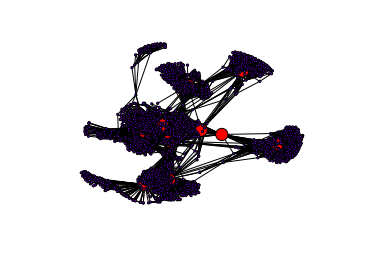

In [20]:
start = timeit.default_timer()
bt = between_parallel(g_fb)
stop = timeit.default_timer()
top = 10

max_nodes =  sorted(bt.iteritems(), key = lambda v: -v[1])[:top]
bt_values = [5]*len(g_fb.nodes())
bt_colors = [0]*len(g_fb.nodes())
for max_key, max_val in max_nodes:
    bt_values[max_key] = 150
    bt_colors[max_key] = 2
    
print 'It takes {} seconds to finish'.format(stop - start)
print max_nodes

Now let's try with just one processor

It takes 283.723123074 seconds to finish
[(107, 0.48051807855601475), (1684, 0.3377974497302), (3437, 0.23611535735892797), (1912, 0.2292953395868785), (1085, 0.14901509211665198), (0, 0.14630592147442847), (698, 0.11533045020560787), (567, 0.09631033121856226), (58, 0.08436020590796657), (428, 0.0643090623932386)]


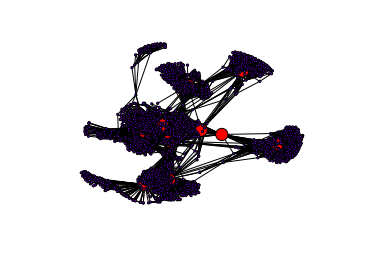

In [22]:
start = timeit.default_timer()
bt = nx.betweenness_centrality(g_fb)
stop = timeit.default_timer()
top = 10

max_nodes =  sorted(bt.iteritems(), key = lambda v: -v[1])[:top]
bt_values = [5]*len(g_fb.nodes())
bt_colors = [0]*len(g_fb.nodes())
for max_key, max_val in max_nodes:
    bt_values[max_key] = 150
    bt_colors[max_key] = 2
 
print 'It takes {} seconds to finish'.format(stop - start)
print max_nodes

# Page rank

We're going to try PageRank algorithm. This is very similar to Google's PageRank which they use incoming links to determine the "popularity"

In [24]:
g_fb_pr = nx.pagerank(g_fb)

In [25]:
top = 10
max_pagerank = sorted(g_fb_pr.iteritems(), key = lambda v: -v[1])[:top]
max_pagerank

[(3437, 0.007614586844749602),
 (107, 0.006936420955866113),
 (1684, 0.006367162138306825),
 (0, 0.006289602618466542),
 (1912, 0.0038769716008844957),
 (348, 0.002348096972780577),
 (686, 0.0022193592598000193),
 (3980, 0.0021703235790099928),
 (414, 0.0018002990470702264),
 (698, 0.0013171153138368812)]

We can see that now the score is different as node 3437 is more popular than node 107.

# Who is a "Gray Cardinal"
There's another metric that we can measure most influential node. It's called eigenvector centrality. To put it simply it means that if you're well connected to a lot of important people that means you're important or most influential as well. 

In [26]:
g_fb_eg = nx.eigenvector_centrality(g_fb)

In [27]:
top = 10
max_eg = sorted(g_fb_eg.iteritems(), key = lambda v: -v[1])[:top]
max_eg

[(1912, 0.09540688873596533),
 (2266, 0.08698328226321961),
 (2206, 0.08605240174265634),
 (2233, 0.08517341350597848),
 (2464, 0.0842787836468596),
 (2142, 0.08419312450068117),
 (2218, 0.08415574433673877),
 (2078, 0.08413617905810125),
 (2123, 0.08367142125897375),
 (1993, 0.08353243711860492)]

Now we get quite a different result. This would mean that node 1912 is connected to more important people in the entire network that means that node is more influential than the rest of the network.

# iGraph with SNAP Facebook Dataset
Networkx is easy to install and great to start with. However, as it's written in Python it's quite slow. I'm going to try iGraph which is C based. I'm hoping that this would yield the same result but faster.

In [5]:
from igraph import *
import timeit

In [6]:
igraph_fb = Graph.Read_Edgelist('facebook_combined.txt', directed=False)

In [7]:
print igraph_fb.summary()

IGRAPH U--- 4039 88234 -- 


# Betweenness

In [8]:
def betweenness_centralization(G):
    vnum = G.vcount()
    if vnum < 3:
        raise ValueError("graph must have at least three vertices")
    denom = (vnum-1)*(vnum-2)
 
    temparr = [2*i/denom for i in G.betweenness()]
    return temparr

In [9]:
start = timeit.default_timer()
igraph_betweenness = betweenness_centralization(igraph_fb)
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 3.41120696068 seconds to finish


In [10]:
igraph_betweenness.sort(reverse=True)
print igraph_betweenness[:10]

[0.4805180785560146, 0.3377974497302, 0.23611535735892794, 0.22929533958687848, 0.14901509211665237, 0.14630592147442847, 0.11533045020560788, 0.09631033121856228, 0.08436020590796657, 0.0643090623932386]


# Closeness

In [11]:
start = timeit.default_timer()
igraph_closeness = igraph_fb.closeness()
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 3.21295285225 seconds to finish


In [12]:
igraph_closeness.sort(reverse=True)
print igraph_closeness[:10]

[0.45969945355191255, 0.3974018305284913, 0.3948371956585509, 0.3939127889961955, 0.39360561458231796, 0.37049270575282134, 0.36991572004397216, 0.3698479575013739, 0.3695433330282786, 0.36655773420479304]


# Eigen Value

In [13]:
start = timeit.default_timer()
igraph_eg = igraph_fb.evcent()
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 0.0219130516052 seconds to finish


In [14]:
igraph_eg.sort(reverse=True)
print igraph_eg[:10]

[1.0, 0.9117190175727714, 0.901962632218424, 0.8927488203018591, 0.8833723691600294, 0.8824740496738581, 0.8820826938160473, 0.8818776189568721, 0.8770062766705519, 0.8755494858467869]


# PageRank

In [15]:
start = timeit.default_timer()
igraph_pr = igraph_fb.pagerank()
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 0.0559718608856 seconds to finish


In [16]:
igraph_pr.sort(reverse=True)
print igraph_pr[:10]

[0.0075745665246258935, 0.006888375869731625, 0.0063084887921967805, 0.0062246948047383005, 0.0038165503710367713, 0.002317366308283276, 0.002216791818397391, 0.002156551114912813, 0.0017822888082657136, 0.00129416751155367]


We can see that iGraph yields similar result from networkx but it's a lot quicker in the same machine.

# Graph_tool with SNAP Facebook Dataset
I'm going to try another library which is supposed to be the fastest than networkx and igraph. Graph_tool is also C based which it has OpenMP enabled so a lot of algorithms is multiprocessing. 

In [1]:
import sys

from graph_tool.all import *
import timeit

In [2]:
show_config()

version: 2.2.44 (commit 178add3a, Thu Jul 2 01:44:54 2015 +0200)
gcc version: 4.2.1
compilation flags:  -I/System/Library/Frameworks/Python.framework/Versions/2.7/include/python2.7 -I/usr/local/include -I/usr/local/lib/python2.7/site-packages/numpy/core/include -I/usr/local/lib/python2.7/site-packages/scipy -I/usr/local/Cellar/google-sparsehash/2.0.2/include  -DSPARSEHASH_PREFIX=sparsehash -Wall -Wextra -ftemplate-backtrace-limit=0  -DNDEBUG -std=gnu++11 -ftemplate-depth-250 -Wno-deprecated -Wno-unknown-pragmas -fvisibility=default -fvisibility-inlines-hidden -Wno-unknown-pragmas -I/usr/local/Cellar/google-sparsehash/2.0.2/include  -DSPARSEHASH_PREFIX=sparsehash  -undefined dynamic_lookup
install prefix: /usr/local/Cellar/graph-tool/2.2.44
python dir: /Library/Python/2.7/site-packages
graph filtering: True
openmp: False
uname: Darwin Noppanits-MacBook-Air.local 14.5.0 Darwin Kernel Version 14.5.0: Wed Jul 29 02:26:53 PDT 2015; root:xnu-2782.40.9~1/RELEASE_X86_64 x86_64


In [3]:
graph_tool_fb = Graph(directed=False)

In [4]:
with open('facebook_combined.txt', 'r') as f:
    for line in f:
        edge_list = line.split()
        source, target = tuple(edge_list)
        graph_tool_fb.add_edge(source, target)

In [5]:
print graph_tool_fb.num_vertices()
print graph_tool_fb.num_edges()

4039
88234


## Betweeness

In [6]:
start = timeit.default_timer()
vertext_betweenness, edge_betweenness = betweenness(graph_tool_fb)
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 36.7536098957 seconds to finish


In [7]:
vertext_betweenness.a[107]

0.48051807855601453

## Closeness

In [8]:
start = timeit.default_timer()
v_closeness = closeness(graph_tool_fb)
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 33.3668859005 seconds to finish


In [9]:
v_closeness.a[107]

0.45969945355191255

## Eigenvalue

In [11]:
start = timeit.default_timer()
v_closeness = eigenvector(graph_tool_fb)
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 0.131196975708 seconds to finish


## Page Rank

In [13]:
start = timeit.default_timer()
v_closeness = pagerank(graph_tool_fb)
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 0.163510084152 seconds to finish


# Information diffusion modelling
I'm going to information diffusion model to simulate how information travels in the graph. 

In [14]:
%matplotlib inline
import random as r
import networkx as nx
import matplotlib.pyplot as plot

Couldn't import dot_parser, loading of dot files will not be possible.


In [15]:
class Person(object):
    def __init__(self, id):
        #Start with a single initial preference
        self.id = id
        self.i = r.random()
        self.a = self.i
        # we value initial opinion and subsequent information equally
        self.alpha = 0.8
    
    def __str__(self):
        return (str(self.id))
    
    def step(self):
        # loop through the neighbors and aggregate their preferences
        neighbors = g[self]
        # all nodes in the list of neighbors are equally weighted, including self
        w = 1/float((len(neighbors) + 1 ))
        s = w * self.a
        for node in neighbors:
            s += w * node.a

        # update my beliefs = initial belief plus sum of all influences
        self.a = (1 - self.alpha) * self.i + self.alpha * s

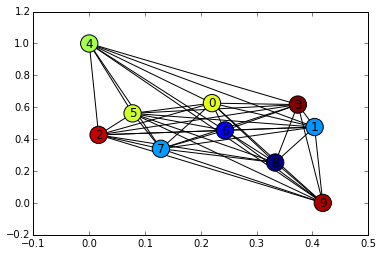

In [16]:
density = 0.9
g = nx.Graph()

## create a network of Person objects
for i in range(10):
    p = Person(i)
    g.add_node(p)
    
## this will be a simple random graph, every pair of nodes has an
## equal probability of connection
for x in g.nodes():
    for y in g.nodes():
        if r.random() <= density:
            g.add_edge(x,y)
            
## draw the resulting graph and color the nodes by their value
col = [n.a for n in g.nodes()]
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos=pos, node_color=col)

[0.45050753135154914, 0.5888690787037506, 0.4423961312885849, 0.5300498998080747, 0.6988731674943652, 0.6795418820824117, 0.6785718311317842, 0.568814202159901, 0.5706430294584026, 0.49632118526941715]
[0.4855296157010143, 0.5856804164323358, 0.47093717928779294, 0.5244620739653998, 0.6496396099696642, 0.6411899282308859, 0.6484393994615059, 0.5720352467769754, 0.5728158036583522, 0.514839066871444]
[0.4852388874069484, 0.5800425201917674, 0.46682024795791915, 0.5160964412252317, 0.6378977198782583, 0.6329660942199506, 0.6430044848703405, 0.5710302747024006, 0.5712191949768373, 0.5141570563368826]
[0.4817926221791012, 0.5759778764271721, 0.46267707497376387, 0.5119459265022431, 0.6338082132037018, 0.6296889831451993, 0.6402899659669313, 0.5689477848037309, 0.568903307620578, 0.5118553740331476]
[0.47917210885991474, 0.5733724448077611, 0.4600881540183551, 0.509553410753053, 0.6315479888743104, 0.6276208808481694, 0.6383507073752878, 0.5671342971746759, 0.5670689867837366, 0.51005710931

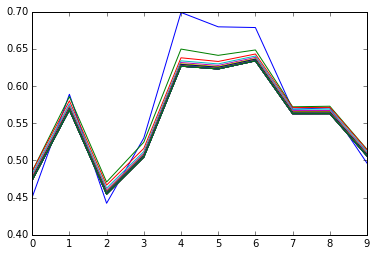

In [17]:
## repeat for 30 times periods
for i in range(30):
    ## iterate through all nodes in the network and tell them to make a step
    for node in g.nodes():
        node.step()
        
    ## collect new attitude data, print it to the terminal and plot it.
    col = [n.a for n in g.nodes()]
    print col
    plot.plot(col)

In [18]:
class Influencer(Person):
    def __ini__(self, id):
        self.id = id
        self.i = r.random()
        self.a = 1 ## opinion is strong and immovable
        
    def step(self):
        pass

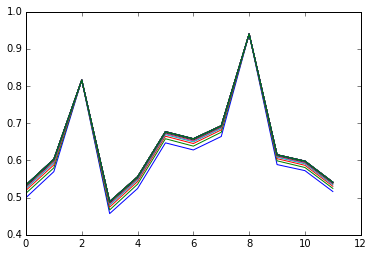

In [19]:
influencers = 2
connections = 4
## add the influencers to the network and connect each to 3 other nodes
for i in range(influencers):
    inf = Influencer("Inf" + str(i))
    for x in range(connections):
        g.add_edge(r.choice(g.nodes()), inf)
        
## repeat for 30 time periods
for i in range(30):
    ## iterate through all nodes in the network and tell them to make a step
    for node in g.nodes():
        node.step()
        
    ## collect new attitude data, print it to the terminal and plot it.
    col = [n.a for n in g.nodes()]
    #print col
    plot.plot(col)

# Networkx Independent Cascade Model

In [20]:
import copy
import networkx as nx
import random

In [28]:
def independent_cascade(G, seeds, steps = 0):
    """
    "Return the active nodes of each diffusion step by the independent cascade
    model

    Parameters
    -- -- -- -- -- -
    G: graph
    A NetworkX graph
    seeds: list of nodes
        The seed nodes for diffusion
    steps: integer
        The number of steps to diffuse.If steps <= 0, the diffusion runs until
        no more nodes can be activated.If steps > 0, the diffusion runs for at
        most "steps" rounds

    Returns
    -- -- -- -
    layer_i_nodes: list of list of activated nodes
    layer_i_nodes[0]: the seeds
    layer_i_nodes[k]: the nodes activated at the kth diffusion step

    Notes
    -- -- -
    When node v in G becomes active, it has a * single * chance of activating
    each currently inactive neighbor w with probability p_ {
        vw
    }

    Examples
    -- -- -- --
    >>> DG = nx.DiGraph() >>> DG.add_edges_from([(1, 2), (1, 3), (1, 5), (2, 1), (3, 2), (4, 2), (4, 3), \ >>> (4, 6), (5, 3), (5, 4), (5, 6), (6, 4), (6, 5)], act_prob = 0.2) >>> H = nx.independent_cascade(DG, [6])

    References
    -- -- -- -- --[1] David Kempe, Jon Kleinberg, and Eva Tardos.
    Influential nodes in a diffusion model
    for social networks.
    In Automata, Languages and Programming, 2005.
    """
    if type(G) == nx.MultiGraph or type(G) == nx.MultiDiGraph:
        raise Exception(\
            "independent_cascade() is not defined for graphs with multiedges.")

    # make sure the seeds are in the graph
    for s in seeds:
        if s not in G.nodes():
            raise Exception("seed", s, "is not in graph")

    # change to directed graph
    if not G.is_directed():
        DG = G.to_directed()
    else:
        DG = copy.deepcopy(G)

    # init activation probabilities
    for e in DG.edges():
        if 'act_prob' not in DG[e[0]][e[1]]:
            DG[e[0]][e[1]]['act_prob'] = 0.1
        elif DG[e[0]][e[1]]['act_prob'] > 1:
            raise Exception("edge activation probability:", DG[e[0]][e[1]]['act_prob'], "cannot be larger than 1")

    # perform diffusion
    A = copy.deepcopy(seeds)# prevent side effect
    if steps <= 0: #perform diffusion until no more nodes can be activated
        return _diffuse_all(DG, A)# perform diffusion for at most "steps" rounds
    return _diffuse_k_rounds(DG, A, steps)

In [29]:
def _diffuse_all(G, A):
    tried_edges = set()
    layer_i_nodes = [ ]
    layer_i_nodes.append([i for i in A])  # prevent side effect
    while True:
        len_old = len(A)
        (A, activated_nodes_of_this_round, cur_tried_edges) = _diffuse_one_round(G, A, tried_edges)
        layer_i_nodes.append(activated_nodes_of_this_round)
        tried_edges = tried_edges.union(cur_tried_edges)
        if len(A) == len_old:
            break
    return layer_i_nodes

In [30]:
def _diffuse_k_rounds(G, A, steps):
    tried_edges = set()
    layer_i_nodes = [ ]
    layer_i_nodes.append([i for i in A])
    while steps > 0 and len(A) < len(G):
        len_old = len(A)
        (A, activated_nodes_of_this_round, cur_tried_edges) = _diffuse_one_round(G, A, tried_edges)
        layer_i_nodes.append(activated_nodes_of_this_round)
        tried_edges = tried_edges.union(cur_tried_edges)
        if len(A) == len_old:
            break
        steps -= 1
    return layer_i_nodes

In [31]:
def _diffuse_one_round(G, A, tried_edges):
    activated_nodes_of_this_round = set()
    cur_tried_edges = set()
    for s in A:
        for nb in G.successors(s):
            if nb in A or (s, nb) in tried_edges or (s, nb) in cur_tried_edges:
                continue
            if _prop_success(G, s, nb):
                activated_nodes_of_this_round.add(nb)
            cur_tried_edges.add((s, nb))
    activated_nodes_of_this_round = list(activated_nodes_of_this_round)
    A.extend(activated_nodes_of_this_round)
    return A, activated_nodes_of_this_round, cur_tried_edges

def _prop_success(G, src, dest):
    return random.random() <= G[src][dest]['act_prob']

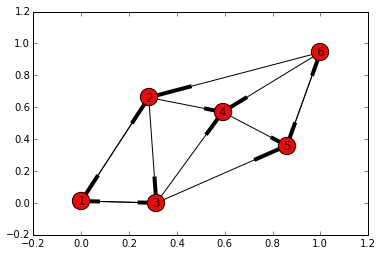

In [32]:
run_times = 10

G = nx.DiGraph()
G.add_edge(1,2,act_prob=.5)
G.add_edge(2,1,act_prob=.5)
G.add_edge(1,3,act_prob=.2)
G.add_edge(3,1,act_prob=.2)
G.add_edge(2,3,act_prob=.3)
G.add_edge(2,4,act_prob=.5)
G.add_edge(3,4,act_prob=.1)
G.add_edge(3,5,act_prob=.2)
G.add_edge(4,5,act_prob=.2)
G.add_edge(5,6,act_prob=.6)
G.add_edge(6,5,act_prob=.6)
G.add_edge(6,4,act_prob=.3)
G.add_edge(6,2,act_prob=.4)
nx.draw_networkx(G)

In [33]:
independent_cascade(G, [1], steps=0)

[[1], []]

In [45]:
n_A = 0.0
for i in range(run_times):
    A = independent_cascade(G, [1], steps=1)
    print A
    for layer in A:
        n_A += len(layer)
n_A / run_times
#assert_almost_equal(n_A / run_times, 1.7, places=1)

[[1], []]
[[1], [2]]
[[1], [2]]
[[1], []]
[[1], [2, 3]]
[[1], [2, 3]]
[[1], []]
[[1], []]
[[1], []]
[[1], []]


1.6

# Conclusion

Both igraph and graph_tool yield similar performance. So, for the real data I'm going to use graph_tool as the documentation is more comprehensive.